In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
from utils import *
from model import *
from data_module import *
import importlib

$
s_i = \delta_i(\frac{1}{n}L(S_{train},F(x,\theta)) - l(y_i,F(x_i,\theta)))
$

In [53]:
def get_new_grads(model, data, current_example_index, fn, device="cpu"):
    '''
    Args 
        model: the model that we want to get the gradients from
        data: the input data
        current_example_index: the index of the example that we want to flip
    Returns
        grads_list: a dictionary of the gradients of the model
        final_preds: the final predictions of the model
    '''
    grads_list = {}

    final_preds = model(data)
    y = torch.tensor([fn(i, j) for i, j in data]).to(device)

    loss = nn.CrossEntropyLoss(reduction = 'none')(final_preds, y)
    batch_size = y.shape[0]
    #for the example that we want to flip, we must reverse the loss while maintaing the population loss
    loss[current_example_index] *= -1*batch_size
    loss = loss.mean()
    loss.backward()

    for name, param in (model.named_parameters()):
        grads_list[name] = copy.deepcopy(param.grad.detach())

    # ipdb.set_trace()
    model.zero_grad()

    return grads_list, final_preds.detach()

# Memorization solution

In [65]:
gene_weight_path = "/home/0116/sgd/adam_WD_1.0_LR_0.001_MO_0.9/final.pth"
memo_weight_path = "/home/0116/sgd/adam_WD_1.0_LR_0.001_MO_0.9/2000.pth"
init_weight_path = "/home/0116/sgd/adam_WD_1.0_LR_0.001_MO_0.9/init.pth"
config_path = "config.config"

train_data = torch.load(init_weight_path)["train_data"]
test_data = torch.load(init_weight_path)["test_data"]
config = importlib.import_module(config_path).Exp()

model= OnlyMLP(
        num_layers=config.num_layers,
        d_vocab=config.d_vocab,
        d_model=config.d_model,
        d_emb=config.d_emb,
        act_type=config.act_type,
        use_ln=config.use_ln,
        weight_scale=config.weight_scale,
        )



train loss:  tensor(5.4968e-07, dtype=torch.float64, grad_fn=<NegBackward0>)
train acc:  1.0
train prob:  tensor(1.0000, grad_fn=<MeanBackward0>)
test_loss:  tensor(19.0388, dtype=torch.float64, grad_fn=<NegBackward0>)
test acc:  0.05531167611479759
test prob:  tensor(0.0579, grad_fn=<MeanBackward0>)


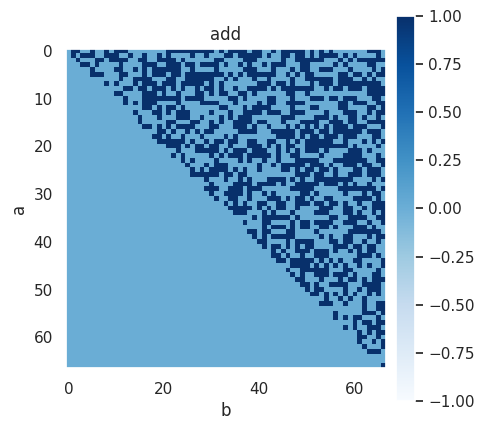

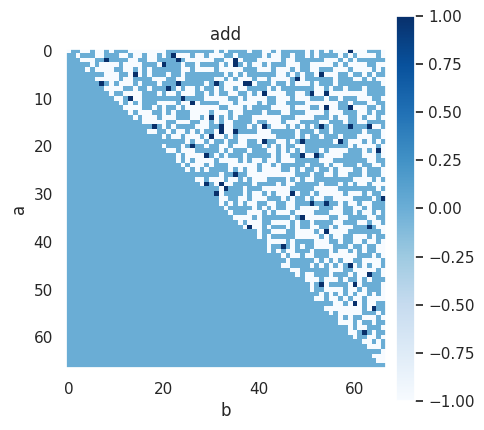

In [62]:
model.load_state_dict(torch.load(memo_weight_path)["model"])
train_loss, train_acc, train_prob, train_sample = full_loss_mlp(
        model, train_data, config.fn, config.p, is_div=config.is_div, device="cpu"
        )
test_loss, test_acc, test_prob, test_sample = full_loss_mlp(
        model, test_data, config.fn, config.p, is_div=config.is_div, device="cpu"
        )

print("train loss: ", train_loss)
print("train acc: ", train_acc)
print("train prob: ", train_prob)
print("test_loss: ", test_loss)
print("test acc: ", test_acc)
print("test prob: ", test_prob)


grads of the example:(38, 65)


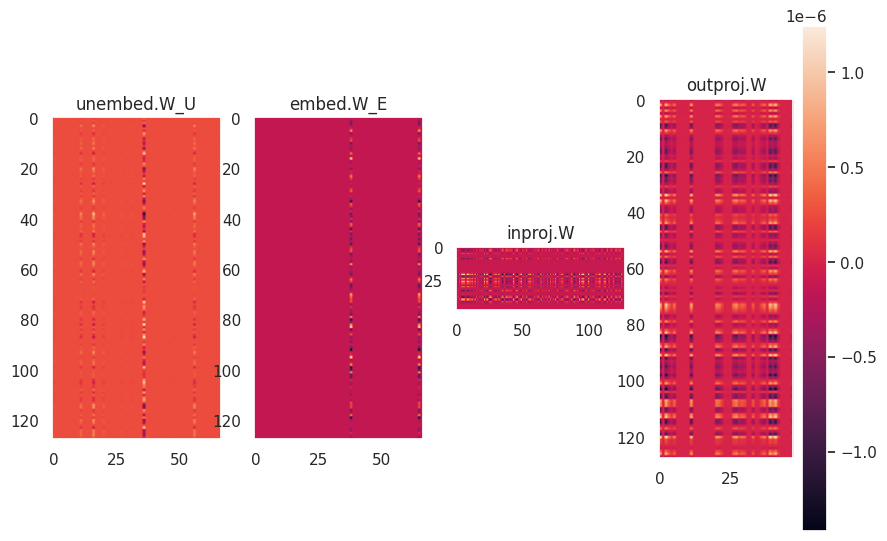

In [63]:
sample_index = 0
grad_lists, final_pred = get_new_grads(model, train_data, sample_index, config.fn, device="cpu")
fig, ax = plt.subplots(1, 4, figsize=(10, 10))

for i, (name, grad) in enumerate(grad_lists.items()):
    ax[i].imshow(grad.cpu().numpy())
    ax[i].grid(False)
    ax[i].set_title(name)
print(f"grads of the example:{train_data[sample_index]}")
plt.colorbar(ax[i].imshow(grad.cpu().numpy()), ax=ax[i])

train loss:  tensor(2.6314e-07, dtype=torch.float64, grad_fn=<NegBackward0>)
train acc:  1.0
train prob:  tensor(1.0000, grad_fn=<MeanBackward0>)
test_loss:  tensor(2.5119e-05, dtype=torch.float64, grad_fn=<NegBackward0>)
test acc:  1.0
test prob:  tensor(1.0000, grad_fn=<MeanBackward0>)


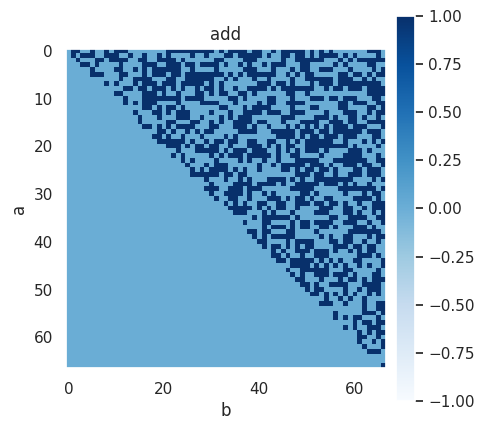

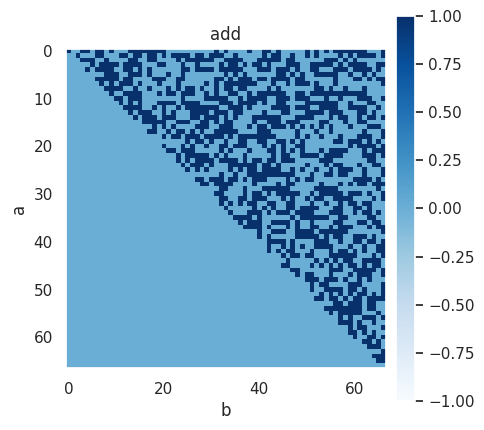

In [66]:
model.load_state_dict(torch.load(gene_weight_path)["model"])
train_loss, train_acc, train_prob, train_sample = full_loss_mlp(
        model, train_data, config.fn, config.p, is_div=config.is_div, device="cpu"
        )
test_loss, test_acc, test_prob, test_sample = full_loss_mlp(
        model, test_data, config.fn, config.p, is_div=config.is_div, device="cpu"
        )

print("train loss: ", train_loss)
print("train acc: ", train_acc)
print("train prob: ", train_prob)
print("test_loss: ", test_loss)
print("test acc: ", test_acc)
print("test prob: ", test_prob)


grads of the example:(38, 65)


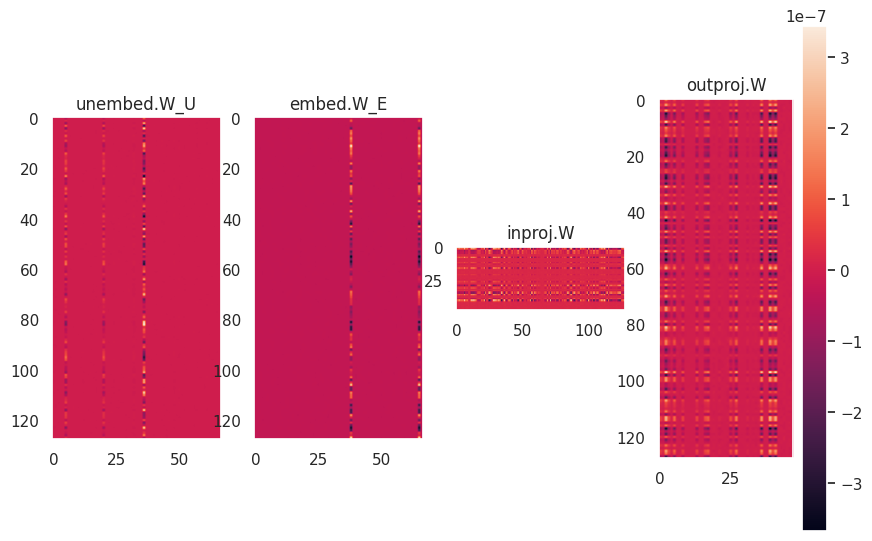

In [67]:
sample_index = 0
grad_lists, final_pred = get_new_grads(model, train_data, sample_index, config.fn, device="cpu")
fig, ax = plt.subplots(1, 4, figsize=(10, 10))

for i, (name, grad) in enumerate(grad_lists.items()):
    ax[i].imshow(grad.cpu().numpy())
    ax[i].grid(False)
    ax[i].set_title(name)
print(f"grads of the example:{train_data[sample_index]}")
plt.colorbar(ax[i].imshow(grad.cpu().numpy()), ax=ax[i])

# Generalized Solution

train loss:  tensor(0.0539, dtype=torch.float64, grad_fn=<NegBackward0>)
train acc:  1.0
train prob:  tensor(0.9482, grad_fn=<MeanBackward0>)
test_loss:  tensor(0.5190, dtype=torch.float64, grad_fn=<NegBackward0>)
test acc:  0.8400890827178955
test prob:  tensor(0.7289, grad_fn=<MeanBackward0>)


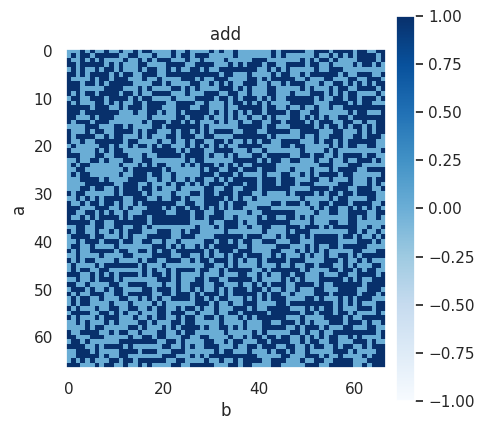

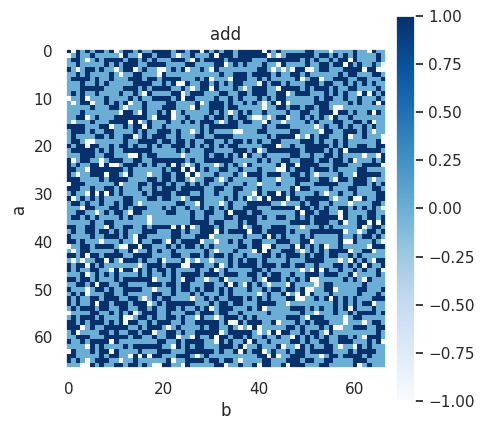

In [43]:
weight_path = "/home/0116/sgd/sgd_WD_0.001_LR_0.01_MO_0.9/final.pth"
init_weight_path = "/home/0116/sgd/sgd_WD_0.001_LR_0.01_MO_0.9/init.pth"
config_path = "config.config"

train_data = torch.load(init_weight_path)["train_data"]
test_data = torch.load(init_weight_path)["test_data"]
config = importlib.import_module(config_path).Exp()

model= OnlyMLP(
        num_layers=config.num_layers,
        d_vocab=config.d_vocab,
        d_model=config.d_model,
        d_emb=config.d_emb,
        act_type=config.act_type,
        use_ln=config.use_ln,
        weight_scale=config.weight_scale,
        )

model.load_state_dict(torch.load(weight_path)["model"])
train_loss, train_acc, train_prob, train_sample = full_loss_mlp(
        model, train_data, config.fn, config.p, is_div=config.is_div, device="cpu"
        )
test_loss, test_acc, test_prob, test_sample = full_loss_mlp(
        model, test_data, config.fn, config.p, is_div=config.is_div, device="cpu"
        )

print("train loss: ", train_loss)
print("train acc: ", train_acc)
print("train prob: ", train_prob)
print("test_loss: ", test_loss)
print("test acc: ", test_acc)
print("test prob: ", test_prob)


unembed.W_U torch.Size([128, 67])
embed.W_E torch.Size([128, 67])
inproj.W torch.Size([48, 128])
outproj.W torch.Size([128, 48])


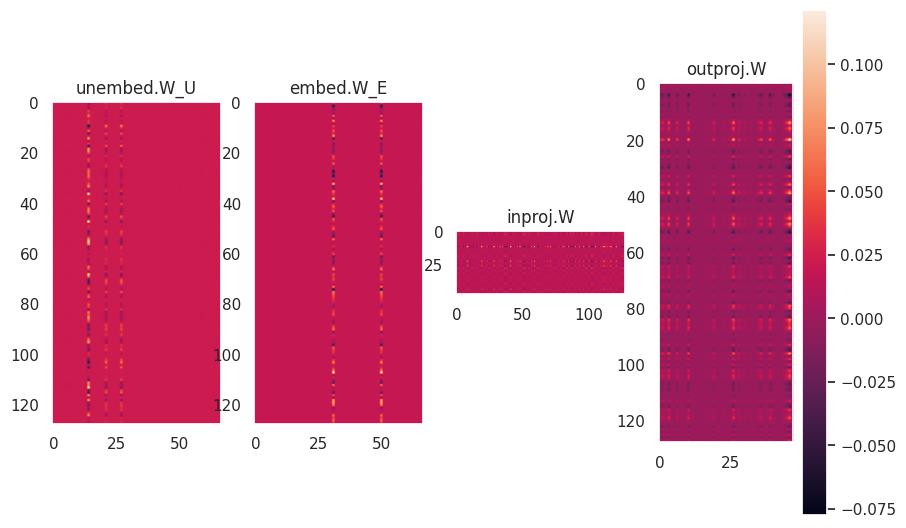

In [44]:
sample_index = 0
grad_lists, final_pred = get_new_grads(model, train_data, sample_index, config.fn, device="cpu")
fig, ax = plt.subplots(1, 4, figsize=(10, 10))

for i, (name, grad) in enumerate(grad_lists.items()):
    print(name, grad.shape)
    ax[i].imshow(grad.cpu().numpy())
    ax[i].grid(False)
    ax[i].set_title(name)
plt.colorbar(ax[i].imshow(grad.cpu().numpy()), ax=ax[i])